In [13]:
#Change to point dataset
"""Backend supported: tensorflow.compat.v1, tensorflow, pytorch, jax, paddle"""
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"  # Disable GPU
os.environ['DDE_BACKEND'] = 'tensorflow.compat.v1'
import deepxde as dde
import numpy as np
from deepxde.backend import tf
import matplotlib.pyplot as plt
import tensorflow as tf

# Set TensorFlow to use all available cores
num_cores = 20
config = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=num_cores, inter_op_parallelism_threads=num_cores,allow_soft_placement=True,device_count={'CPU': num_cores})
session = tf.compat.v1.Session(config=config)
tf.compat.v1.keras.backend.set_session(session)

D = 3.8e-11 #m^2/s
l = 50 #mm
t = 1e2 #s
geom = dde.geometry.Interval(0, l)
timedomain = dde.geometry.TimeDomain(0, t)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

def pde(x, y):
    dy_t = dde.grad.jacobian(y, x, i=0, j=1)
    dy_xx = dde.grad.hessian(y, x, i=0, j=0)
    return (dy_t- D*dy_xx)

def fun_bc(x):
    
    return 100 - 100/l*x[:,0:1]

def fun_init(x):
  
    return 0*x[:,0:1]

data_points = np.matrix([[0.05, 1e5, 9.86688614e-35],
                [0.35, 18e4, 2.80E-20],
                [25.4, 1214e4, 40.4857407],
                [40.75, 1848e4, 79.3099365],
                [48.35, 1999e4, 96.3708344],
                [0.6,24e4, 1.37249327e-17],
                [1.55,169e4, 0.0405000916],
                [30.15,267e4, 16.3269901],
                [43.2,1541e4, 83.7792282],
                [36.75,1704e4, 69.8383331]])


tt=np.reshape(data_points[:, 1], (-1,1))
xx=np.reshape(data_points[:, 0], (-1,1))
cc=np.reshape(data_points[:, 2:], (-1,1))

bc_a = dde.icbc.DirichletBC(geomtime, fun_bc, lambda _, on_boundary: on_boundary, component=0)
bc_b = dde.icbc.DirichletBC(geomtime, fun_bc, lambda _, on_boundary: on_boundary, component=1)
ic1 = dde.icbc.IC(geomtime, fun_init, lambda _, on_initial: on_initial, component=0)
ic2 = dde.icbc.IC(geomtime, fun_init, lambda _, on_initial: on_initial, component=1)

observe_x= np.reshape(np.hstack((xx,tt)),(-1,2))
observe_y = dde.icbc.PointSetBC(observe_x, cc, component=0)


data = dde.data.TimePDE(
    geomtime,
    pde,
    [observe_y],
    num_domain=200,
    num_boundary=100,
    num_initial=100,
    anchors=observe_x,
    num_test=50000,
)

layer_size = [2] + [32] * 3 + [1]
activation = "tanh"
initializer = "Glorot uniform"
net = dde.nn.FNN(layer_size, activation, initializer)
model = dde.Model(data, net)
model.compile("adam", lr=0.00001)
losshistory, train_state = model.train(iterations=100000)
#early_stopping = dde.callbacks.EarlyStopping(min_delta=1e-6, patience=500)
#losshistory, train_state = model.train(iterations=100, callbacks=[early_stopping])
dde.saveplot(losshistory, train_state, issave=True, isplot=True)



Compiling model...
Building feed-forward neural network...
'build' took 0.088570 s



c:\Users\yesda\anaconda3\Lib\site-packages\deepxde\nn\tensorflow_compat_v1\fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 0.560955 s

Training model...

0         [6.78e-04, 2.94e+03]    [5.31e-04, 2.94e+03]    []  
1000      [8.99e-03, 2.82e+03]    [2.07e-03, 2.82e+03]    []  


KeyboardInterrupt: 

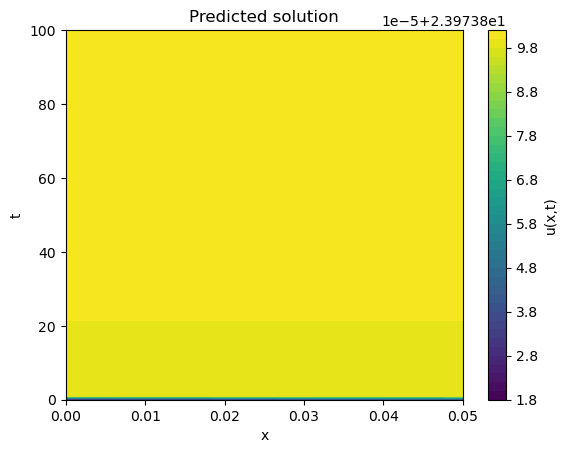

Saving loss history to c:\Users\yesda\OneDrive - Aalto University\Aalto Work\2023Hydrogen\Code\PINN_testing\loss.dat ...
Saving training data to c:\Users\yesda\OneDrive - Aalto University\Aalto Work\2023Hydrogen\Code\PINN_testing\train.dat ...
Saving test data to c:\Users\yesda\OneDrive - Aalto University\Aalto Work\2023Hydrogen\Code\PINN_testing\test.dat ...


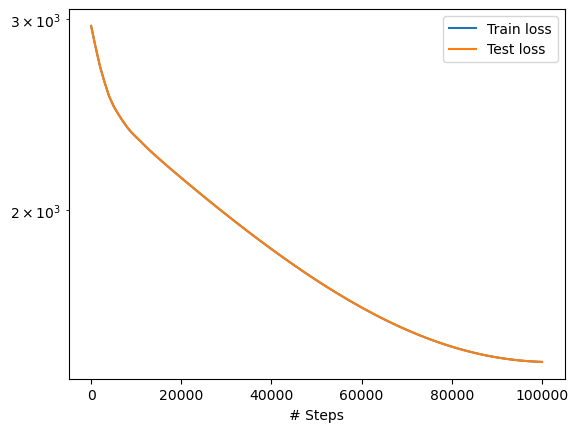

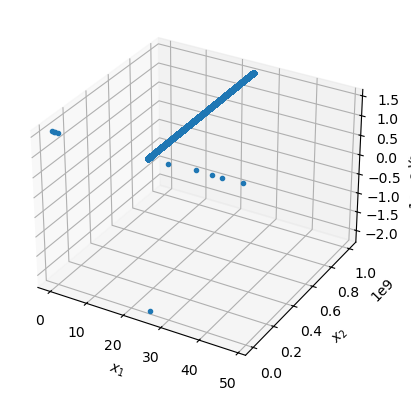

In [12]:
import matplotlib.pyplot as plt
import numpy as np

# Create a grid of points to evaluate the solution
x = np.linspace(0, 0.05, 100)
t = np.linspace(0, 100,100)
X, T = np.meshgrid(x, t)
points = np.vstack([X.ravel(), T.ravel()]).T

# Predict the solution at these grid points
y_pred = model.predict(points).reshape(X.shape)

# Plot the solution
plt.contourf(X, T, y_pred, levels=50, cmap='viridis')
plt.colorbar(label='u(x,t)')
plt.xlabel('x')
plt.ylabel('t')
plt.title('Predicted solution')
plt.show()

# Save the plot and loss history
dde.saveplot(losshistory, train_state, issave=True, isplot=True)
